In [1]:
# Importing useful libraries

from os.path import join

from pandas import read_csv, DataFrame

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from anonymization_tools import get_date_exam

# Defining local variables
data_path = 'C:/Users/b_charmettant/data/parotide_ml/'


In [2]:
# Defining tools function

def get_feature_importance(feature_importance, id_to_key, subset_dict=None):
    non_zero_id = np.nonzero(feature_importance)
    
    feature_importance_dict = {}
    
    for i in non_zero_id[0]:
        if subset_dict is None:
            feature_importance_dict[id_to_key[i]] = feature_importance[i]
        else:
            feature_importance_dict[id_to_key[subset_dict[i]]] = feature_importance[i]
            
    
    # sorting the dict by decreasing feature importance
    feature_importance_dict = order_dict(feature_importance_dict)
        
    return feature_importance_dict

def get_feature_subset(id_to_key, subset):

    subset_ids = np.random.choice(len(id_to_key), subset)
    
    subset_dict = dict(zip(range(subset), subset_ids))
    
    return subset_ids, subset_dict
    
    

def bootstrap_feature_selection(features, labels, cls, id_to_key, nb_try=100, subset=None, auc=True):
      
    overall_importance = dict(zip(key_to_id.keys(), np.zeros(len(key_to_id))))
    avg_w = 0
    
    n_skipped = 0
    
    for _ in range(nb_try):
        x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.15)
        
        if auc and (sum(y_test) == 0 or sum(y_test) == len(y_test)):
            n_skipped += 1
            continue
        
        subset_dict = None
        if subset is not None:
            feature_subset, subset_dict = get_feature_subset(id_to_key, subset)
            # print(subset_dict)
            
            x_train = x_train[:, feature_subset]
            x_test = x_test[:, feature_subset]
            

        
        clf.fit(x_train, y_train)
        predictions_test = np.array(clf.predict_proba(x_test))[:,1]
        
        ft_importance = get_feature_importance(clf.feature_importances_, id_to_key, subset_dict=subset_dict)
        # print(ft_importance)
        
        if auc:
            w = (metrics.roc_auc_score(y_test, predictions_test) - 0.5)*2
        else:
            w = 1 - np.linalg.norm(y_test - predictions_test)/np.sqrt(len(y_test))
        
        for k,v in ft_importance.items():
            overall_importance[k] += v * w
           
        avg_w += w/nb_try
        
    print(f'Average weight {avg_w}')
    print(f"Number of round skipped : {n_skipped}")
        
    return order_dict(overall_importance)

def get_threshold(values, percentile=0.75):
    plt.plot( range(len(values)), values)
    plt.show()
    return np.percentile(values, percentile)
    
    

In [3]:
df_meta = get_meta_data(data_path)
df_meta.head()

# TODO: insert here a description of the dataframe (nb_classes, repartition among classes etc...)

,id,sexe,age,type_irm,classe,malin
0,parotide_1,0,79.0,1.0,2,0
1,parotide_2,1,87.0,3.0,1,0
2,parotide_3,0,29.0,3.0,1,0
3,parotide_4,1,34.0,3.0,1,0
4,parotide_5,1,68.0,1.0,4,1


In [4]:
ls_exams, id_to_key, key_to_id = load_features(df_meta, data_path, verbose=False, type_to_include=['t1', 't2', 'gado', 'diff'])

features = []
labels = []

for exam in ls_exams:
    lbl, ft = format_exam(exam, key_to_id)
    features.append(ft)
    labels.append(lbl)

In [5]:
features = np.array(features)
labels = np.array(labels)

print(f"{len(labels)} with {len(features[0])} features")
print(f"Labels : {len(labels) - sum(labels)} benign lesions and {sum(labels)} malignant")

scaler = StandardScaler()
rescaled_features = scaler.fit_transform(features)

104 with 432 features
Labels : 57 benign lesions and 47 malignant


In [6]:
# Split between test and train set
x_train, x_test, y_train, y_test = train_test_split(rescaled_features, labels, test_size=0.25)
print(f"Training : {len(x_train)} samples - Testing : {len(x_test)} samples.")

Training : 78 samples - Testing : 26 samples.


In [7]:
# Dimensionality reduction
clf = RandomForestClassifier(n_estimators=100, verbose=0, max_features=5, max_depth=None)
feature_importance = bootstrap_feature_selection(x_train, y_train, clf, id_to_key, nb_try=1000, subset=50, auc=True)

Average weight 0.016604608585858594
Number of round skipped : 0


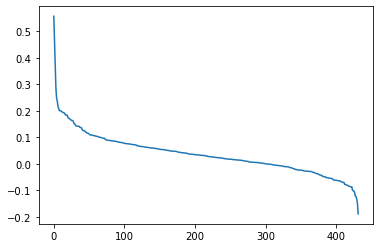

1 - t1_OriginalShapeCompactness2 - 0.5569223370415198
2 - t1_OriginalShapeCompactness1 - 0.4658434267944902
3 - t2_OriginalFirstOrderRange - 0.37003799757528033
4 - t1_OriginalShapeSphericity - 0.28542098340775346
5 - gado_OriginalGrayLevelRunLengthMatrixLongRunHighGrayLevelEmphasis - 0.24741908422525002
6 - t1_OriginalGrayLevelRunLengthMatrixLongRunLowGrayLevelEmphasis - 0.23612759262976896
7 - t2_OriginalGrayLevelDependenceMatrixDependenceVariance - 0.21566602724549014
8 - t2_OriginalFirstOrderMean - 0.20832052221419642
9 - gado_OriginalGrayLevelCo-occurrenceMatrixInformalMeasureofCorrelation2 - 0.20049492721941434
10 - t1_OriginalGrayLevelRunLengthMatrixLowGrayLevelRunEmphasis - 0.20042645524545


In [8]:
significant_features = []

threshold = get_threshold(list(feature_importance.values()), percentile=90)

c = 0

for key in feature_importance.keys():
    if feature_importance[key] > threshold:
        significant_features.append(key_to_id[key])
        
        if c < 10:
            c+=1
            print(f"{c} - {key} - {feature_importance[key]}")

significant_features_dict = dict(zip(range(len(significant_features)), significant_features))
        
new_features = rescaled_features[:, significant_features]

x_train = x_train[:, significant_features]
x_test = x_test[:, significant_features]

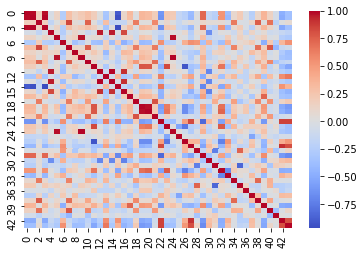

In [9]:
df_features = DataFrame(new_features)
cor = df_features.corr()
    
sns.heatmap(cor, cmap='coolwarm')
plt.show()

In [10]:
clf = RandomForestClassifier(n_estimators=3, verbose=0, max_features=3, max_depth=None)
# clf = SVC(C=2, probability=True)
# clf = LinearSVC(penalty="l1", C=1)
# clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
predictions_train = np.array(clf.predict_proba(x_train))[:,1]
predictions_test = np.array(clf.predict_proba(x_test))[:,1]

In [12]:
# get_feature_importance(clf.feature_importances_, id_to_key)

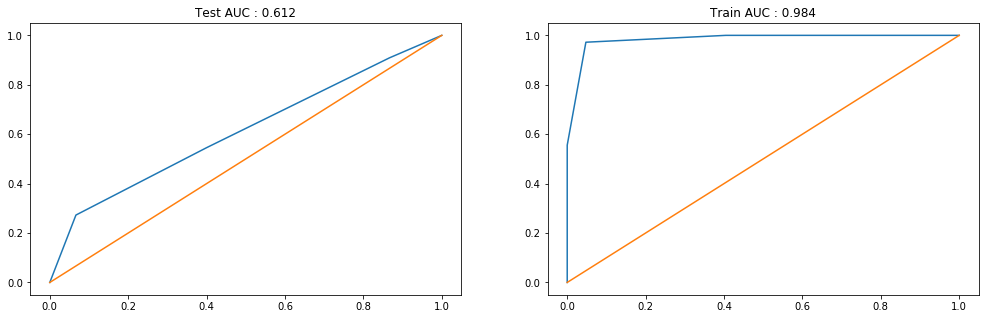

In [13]:
plt.rcParams['figure.figsize'] = (17, 5)

# Calculating AUC
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions_test)
auc = metrics.roc_auc_score(y_test, predictions_test)

plt.subplot(1,2,1)
plt.title("Test AUC : {:.3f}".format(auc))
plt.plot(fpr,tpr)
plt.plot(fpr, fpr)

fpr, tpr, _ = metrics.roc_curve(y_train,  predictions_train)
auc = metrics.roc_auc_score(y_train, predictions_train)
plt.subplot(1,2,2)
plt.title("Train AUC : {:.3f}".format(auc))
plt.plot(fpr,tpr)
plt.plot(fpr, fpr)
plt.show()

In [14]:
get_feature_importance(clf.feature_importances_, id_to_key, subset_dict=significant_features_dict)

{'t1_OriginalFirstOrderMedian': 0.09964144004354292,
 'gado_OriginalFirstOrderTotalEnergy': 0.09128531847521618,
 'diff_OriginalFirstOrderMedian': 0.08924800559751783,
 'gado_OriginalGrayLevelCo-occurrenceMatrixInformalMeasureofCorrelation2': 0.07731957066021541,
 't1_OriginalShapeSphericalDisproportion': 0.0687749315278128,
 'gado_OriginalGrayLevelCo-occurrenceMatrixSumAverage': 0.06767962983827439,
 't1_OriginalGrayLevelRunLengthMatrixGrayLevelVariance': 0.052000041407076154,
 't2_OriginalGrayLevelCo-occurrenceMatrixClusterShade': 0.04453655921637821,
 'diff_OriginalFirstOrderRange': 0.043960028559759064,
 'gado_OriginalNeighboringGrayToneDifferenceMatrixContrast': 0.039117560604488705,
 't1_OriginalGrayLevelCo-occurrenceMatrixSumEntropy': 0.036782389723566206,
 't1_OriginalGrayLevelCo-occurrenceMatrixSumofSquares': 0.03408246014455166,
 't1_OriginalGrayLevelRunLengthMatrixLongRunLowGrayLevelEmphasis': 0.03385077276524645,
 't1_OriginalShapeCompactness1': 0.033163265306122444,
 't2_O